#Complexity Loss as a Biomarker for Alzheimer's Disease

## Installation des librairies


In [5]:
!pip install -q kagglehub pillow matplotlib scikit-learn seaborn


## Configuration Kaggle

In [6]:
from google.colab import files
import os
import json

!mkdir -p ~/.kaggle

kaggle_credentials = {
    "username": "zaitinesnawel",
    "key": "1420cf20f7cc132b17b484f588ddfe9f"
}

with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_credentials, f)

!chmod 600 /root/.kaggle/kaggle.json

print("Kaggle authentication configured!")

Kaggle authentication configured!


## Imports

In [7]:
import numpy as np
import gzip
import bz2
import lzma
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from skimage.filters import sobel

import seaborn as sns
import kagglehub

plt.style.use('default')
sns.set_palette("husl")

In [8]:
def to_uint8(img):
  """Convertit une image en uint8"""
  img = np.nan_to_num(img)
  mn, mx = img.min(), img.max()
  if mx == mn:
      return np.zeros_like(img, dtype=np.uint8)
  scaled = 255 * (img - mn) / (mx - mn)
  return scaled.astype(np.uint8)


## 1 - Mesure de complexité

In [9]:
def kolmogorov_complexity(data, method='gzip'):
    """Approximation K-complexity via compression"""
    if isinstance(data, np.ndarray):
        data = data.tobytes()

    original_size = len(data)
    if original_size == 0:
        return 0.0

    if method == 'gzip':
        compressed = gzip.compress(data, compresslevel=9)
    elif method == 'bz2':
        compressed = bz2.compress(data, compresslevel=9)
    elif method == 'lzma':
        compressed = lzma.compress(data, preset=9)
    else:
        raise ValueError(f"Unknown method: {method}")

    compressed_size = len(compressed)
    return compressed_size / original_size


def conditional_complexity(image1, image2, method='gzip'):
    """Distance informationnelle entre deux images"""
    if isinstance(image1, np.ndarray):
        image1 = image1.tobytes()
    if isinstance(image2, np.ndarray):
        image2 = image2.tobytes()

    cx = len(gzip.compress(image1))
    cy = len(gzip.compress(image2))
    cxy = len(gzip.compress(image1 + image2))

    nid = (cxy - min(cx, cy)) / max(cx, cy)
    return nid


def regional_complexity_map(image, grid_size=8):
    """Carte de complexité régionale"""
    h, w = image.shape
    step_h = h // grid_size
    step_w = w // grid_size

    complexity_map = np.zeros((grid_size, grid_size))

    for i in range(grid_size):
        for j in range(grid_size):
            region = image[i*step_h:(i+1)*step_h, j*step_w:(j+1)*step_w]
            complexity_map[i, j] = kolmogorov_complexity(region)

    return complexity_map

def conditional_kx_given_y(x, y, method="gzip"):
    x_bytes = x.tobytes()
    y_bytes = y.tobytes()

    if method == "gzip":
        Cy = len(gzip.compress(y_bytes))
        Cyx = len(gzip.compress(y_bytes + x_bytes))
    else:
        raise NotImplementedError()

    return Cyx - Cy


In [10]:
def shannon_entropy(img, bins=256):
  """Entropie de Shannon"""
  h, _ = np.histogram(img.ravel(), bins=bins)
  p = h / h.sum()
  p = p[p>0]
  return -np.sum(p * np.log2(p))


In [11]:
def resize_image(image, scale):
    """Redimensionne une image par un facteur"""
    h, w = image.shape
    new_h, new_w = int(h * scale), int(w * scale)
    img_pil = Image.fromarray(image)
    img_resized = img_pil.resize((new_w, new_h), Image.LANCZOS)
    return np.array(img_resized)


def extract_patches(image, size=32):
    """Extrait des patches non-overlapping"""
    h, w = image.shape
    patches = []
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patches.append(image[i:i+size, j:j+size])
    return patches


def compress_ratio(data, method='gzip'):
    """Wrapper pour kolmogorov_complexity"""
    return kolmogorov_complexity(data, method)

## 2 - Chargement des donnés

In [12]:
def explore_dataset_structure(dataset_path):
    """Explore la structure du dataset"""
    dataset_path = Path(dataset_path)

    def print_tree(directory, prefix="", max_depth=3, current_depth=0):
        if current_depth > max_depth:
            return

        items = sorted(directory.iterdir())
        dirs = [item for item in items if item.is_dir()]
        files = [item for item in items if item.is_file()]

        for i, subdir in enumerate(dirs):
            is_last = (i == len(dirs) - 1) and len(files) == 0
            print(f"{prefix}{'└── ' if is_last else '├── '} {subdir.name}")

            img_count = len(list(subdir.glob('*.jpg'))) + len(list(subdir.glob('*.png')))
            if img_count > 0:
                print(f"{prefix}{'    ' if is_last else '│   '}    ({img_count} images)")

            new_prefix = prefix + ("    " if is_last else "│   ")
            print_tree(subdir, new_prefix, max_depth, current_depth + 1)

    print_tree(dataset_path)
    print()


def load_mri_dataset_from_kaggle():
    """Télécharge et charge le dataset"""
    path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")
    print(f" Dataset downloaded to: {path}\n")

    return load_mri_dataset_from_path(path)


def load_mri_dataset_from_path(dataset_path):
    """Charge le dataset depuis un path"""
    dataset_path = Path(dataset_path)
    explore_dataset_structure(dataset_path)

    category_keywords = {
        'no': ('No Impairment', 0),
        'very mild': ('Very Mild Impairment', 1),
        'mild': ('Mild Impairment', 2),
        'moderate': ('Moderate Impairment', 3)
    }

    label_names = ['No Impairment', 'Very Mild Impairment',
                   'Mild Impairment', 'Moderate Impairment']

    images = []
    labels = []


    def scan_directory(directory, depth=0):
        if depth > 5:
            return

        for item in directory.iterdir():
            if item.is_dir():
                folder_name_lower = item.name.lower()

                matched = False
                for keyword, (category_name, label) in category_keywords.items():
                    if keyword in folder_name_lower:
                        img_files = list(item.glob('*.jpg')) + list(item.glob('*.png'))

                        for img_path in img_files:
                            try:
                                img = Image.open(img_path).convert('L')
                                img = img.resize((128, 128))
                                images.append(np.array(img))
                                labels.append(label)
                            except Exception as e:
                                print(f" Error: {img_path.name}")

                        if len(img_files) > 0:
                            print(f"   {category_name}: {len(img_files)} images (from {item.name})")
                        matched = True
                        break

                if not matched:
                    scan_directory(item, depth + 1)

    scan_directory(dataset_path)

    if len(images) == 0:
        print("\n No images found!")
        return np.array([]), np.array([]), label_names

    return np.array(images), np.array(labels), label_names

## 3 - Extraction des features


In [13]:
def extract_rich_features(image):
    """Features enrichies - VERSION CORRIGÉE"""
    features = []

    # 1. Multi-scale compression
    for scale in [0.25, 0.5, 1.0]:
        resized = resize_image(image, scale)
        features.append(compress_ratio(resized, 'gzip'))

    # 2. Régions anatomiques approximatives
    h, w = image.shape
    hippocampus = image[int(h*0.5):int(h*0.8), int(w*0.3):int(w*0.7)]
    cortex = image[int(h*0.15):int(h*0.5), :]
    features.append(compress_ratio(hippocampus, 'gzip'))
    features.append(compress_ratio(cortex, 'gzip'))

    # 3. Variabilité locale
    patches = extract_patches(image, size=32)
    if len(patches) > 0:
        patch_complexities = [compress_ratio(p, 'gzip') for p in patches]
        features.append(np.std(patch_complexities))
        features.append(np.mean(patch_complexities))
    else:
        features.extend([0, 0])

    # 4. Complexité des gradients
    edges = sobel(image.astype(float))
    features.append(compress_ratio(edges.astype(np.uint8), 'gzip'))

    #shannon
    features.append(shannon_entropy(image))

    # 5. Multi-compressor ensemble
    features.append(compress_ratio(image, 'gzip'))
    features.append(compress_ratio(image, 'bz2'))
    features.append(compress_ratio(image, 'lzma'))

    return np.array(features)


def extract_complexity_features(images, verbose=True):
    """Extrait features pour tous les images"""
    features = []
    n = len(images)

    for idx, img in enumerate(images):
        if verbose and (idx + 1) % 100 == 0:
            print(f"   Processing: {idx+1}/{n}")
        features.append(extract_rich_features(img))

    return np.array(features)


# 4-Classification

# AIT Classfication

# Image Classifcation

#-Classification MDL

In [14]:

def mdl_classifier(X_train, y_train, X_test, verbose=True):
    """Classifieur MDL basique"""
    classes = np.unique(y_train)
    prototypes = {}

    for c in classes:
        class_images = X_train[y_train == c]
        prototypes[c] = np.mean(class_images, axis=0).astype(np.uint8)
        print(f"   Class {c}: {len(class_images)} samples")

    predictions = []
    n = len(X_test)

    for idx, test_img in enumerate(X_test):
        if verbose and (idx + 1) % 50 == 0:
            print(f"   {idx+1}/{n}")

        min_complexity = float('inf')
        predicted_class = None

        for c, prototype in prototypes.items():
            complexity = conditional_complexity(test_img, prototype)

            if complexity < min_complexity:
                min_complexity = complexity
                predicted_class = c

        predictions.append(predicted_class)

    return np.array(predictions)


# - Classification CRT

In [15]:
def crt_classifier(images_train, labels_train, images_test):
    # complexity globale moyenne pour chaque classe
    cr0 = np.mean([ compress_ratio(img) for img, label in zip(images_train, labels_train) if label==0])
    cr1 = np.mean([compress_ratio(img) for img, label in zip(images_train, labels_train) if label==1])
    threshold = (cr0 + cr1) / 2
    # prédiction
    preds = []
    for img in images_test:
        cr = compress_ratio(img)
        preds.append(1 if cr < threshold else 0)
    return np.array(preds)


# - Classification BNN

In [16]:
def bnn_classifier(images_train, labels_train, images_test, method='gzip'):
    preds = []
    for img_test in images_test:
        min_dist = float("inf")
        best_label = None
        for img_train, label in zip(images_train, labels_train):
            dist = conditional_complexity(img_test, img_train, method)
            if dist < min_dist:
                min_dist = dist
                best_label = label
        preds.append(best_label)
    return np.array(preds, dtype=int)




# - Classification ckc

In [17]:
def ckc_classifier(train_images, train_labels, test_images):
    classes = np.unique(train_labels)
    pred = []

    for img_test in test_images:
        scores = {}
        for c in classes:
            imgs_c = [train_images[i] for i in range(len(train_images)) if train_labels[i] == c]
            vals = [conditional_kx_given_y(img_test, t) for t in imgs_c]
            scores[c] = np.mean(vals)

        pred.append(min(scores, key=scores.get))

    return np.array(pred)

# **Features Classification**

# Classification MDL

In [18]:
def mdl_classifier_features(X_train, y_train, X_test, verbose=True):
    """MDL classifier optimisé et vectorisé pour features."""

    # 1. Compute prototypes
    classes = np.unique(y_train)
    prototypes = np.vstack([X_train[y_train == c].mean(axis=0) for c in classes])
    # prototypes shape = (num_classes, feature_dim)

    # 2. Compute all distances in one shot
    #    distances[i, j] = || X_test[i] - prototypes[j] ||
    diff = X_test[:, None, :] - prototypes[None, :, :]
    distances = np.linalg.norm(diff, axis=2)

    # 3. Pick nearest prototype per test sample
    class_indices = np.argmin(distances, axis=1)

    # 4. Map indices back to class labels
    predictions = classes[class_indices]

    return predictions



# Classification CRT

In [19]:
def crt_classifier_features(X_train_features, y_train, X_test_features):
    # On prend la première feature KC comme approximation du ratio
    cr0 = X_train_features[y_train==0][:,0].mean()
    cr1 = X_train_features[y_train==1][:,0].mean()
    threshold = (cr0 + cr1)/2

    preds = [1 if x[0]<threshold else 0 for x in X_test_features]
    return np.array(preds)


# Classification BNN

In [20]:
def bnn_classifier_features(X_train_features, y_train, X_test_features):
    preds = []
    for x in X_test_features:
        dists = np.linalg.norm(X_train_features - x, axis=1)
        idx_min = np.argmin(dists)
        preds.append(y_train[idx_min])
    return np.array(preds)


# Classification CKC

In [21]:
def ckc_features(x, y):
    """Approximation CKC sur vecteurs de features"""
    # distance normalisée entre vecteurs
    return np.linalg.norm(x - y) / (np.linalg.norm(x) + np.linalg.norm(y) + 1e-8)


## 4 - Classical ML

Linear Regression

In [22]:
def logistic_regression_classifier(X_train, y_train, X_test):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled  = scaler.transform(X_test)
  logreg = LogisticRegression(max_iter=500)
  logreg.fit(X_train_scaled, y_train)
  y_pred= logreg.predict(X_test_scaled)
  return y_pred

RAndom Forest

In [23]:
def random_forest_classifier(X_train, y_train, X_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    return rf.predict(X_test)

Gradient Boosting

In [24]:
def gradient_boosting_classifier(X_train, y_train, X_test):
    gb = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    return gb.predict(X_test)

SVM

In [25]:
def svm_classifier(X_train, y_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train_scaled, y_train)
    return svm.predict(X_test_scaled)

## 5 - Visualisation

In [26]:
def plot_complexity_evolution(images, labels, label_names):
    """Visualise l'évolution de la complexité"""
    complexities = []

    for idx, img in enumerate(images):
        if (idx + 1) % 100 == 0:
            print(f"   {idx+1}/{len(images)}")
        complexities.append(kolmogorov_complexity(img))

    complexities = np.array(complexities)

    for label, name in enumerate(label_names):
        mask = (labels == label)
        if np.sum(mask) > 0:
            mean_c = np.mean(complexities[mask])
            std_c = np.std(complexities[mask])
            print(f"  {name}: {mean_c:.4f} ± {std_c:.4f}")

    plt.figure(figsize=(12, 6))

    colors = ['green', 'yellow', 'orange', 'red']
    for label, name in enumerate(label_names):
        mask = (labels == label)
        if np.sum(mask) > 0:
            plt.scatter(np.full(np.sum(mask), label), complexities[mask],
                       alpha=0.6, label=name, color=colors[label], s=50)

    means = [np.mean(complexities[labels == l]) for l in range(len(label_names))]
    plt.plot(range(len(label_names)), means, 'k--', linewidth=2, label='Mean trend')

    plt.xlabel('Disease Stage', fontsize=12)
    plt.ylabel('Compression Ratio (↓ = more complex)', fontsize=12)
    plt.title('Complexity Loss Across Alzheimer\'s Stages\n(AIT Hypothesis Test)', fontsize=14)
    plt.xticks(range(len(label_names)), label_names, rotation=20, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def visualize_anomaly_detection(image, label, label_name):
    """Visualise les zones d'anomalie"""
    comp_map = regional_complexity_map(image, grid_size=16)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f'Original MRI\n{label_name}', fontsize=12)
    axes[0].axis('off')

    im = axes[1].imshow(comp_map, cmap='hot', interpolation='nearest')
    axes[1].set_title('Complexity Map\n(darker = simpler)', fontsize=12)
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    axes[1].axis('off')

    threshold = np.percentile(comp_map, 25)
    anomaly_mask = comp_map < threshold
    axes[2].imshow(image, cmap='gray')
    axes[2].imshow(anomaly_mask, cmap='Reds', alpha=0.4)
    axes[2].set_title('Low-Complexity Regions\n(Potential Atrophy)', fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


def compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_mdl,y_pred_rf, label_names,ait_text,ml_text):
    """Compare un model AIT  avec un modele classique de machine learning"""


    acc_mdl = accuracy_score(y_test, y_pred_mdl)
    acc_rf = accuracy_score(y_test, y_pred_rf)



    print(f"\n MDL Classifier (AIT-based):")
    print(f"   Accuracy: {acc_mdl:.2%}")
    print(classification_report(y_test, y_pred_mdl, target_names=label_names))

    print(f"\n Random Forest:")
    print(f"   Accuracy: {acc_rf:.2%}")
    print(classification_report(y_test, y_pred_rf, target_names=label_names))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    cm_mdl = confusion_matrix(y_test, y_pred_mdl)
    cm_rf = confusion_matrix(y_test, y_pred_rf)

    sns.heatmap(cm_mdl, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names, ax=axes[0])
    axes[0].set_title(f'{ait_text}\nAccuracy: {acc_mdl:.2%}')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
                xticklabels=label_names, yticklabels=label_names, ax=axes[1])
    axes[1].set_title(f'{ml_text}\nAccuracy: {acc_rf:.2%}')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

In [27]:
from scipy.stats import kruskal
import numpy as np

def test_global_kruskal(complexities, labels, label_names):
    """
    Performs the global Kruskal–Wallis test across all Alzheimer stages.
    Returns the p-value and prints the test summary.
    """

    groups = []
    for i, name in enumerate(label_names):
        groups.append(complexities[labels == i])

    stat, p = kruskal(*groups)

    print("\n=== Global Kruskal–Wallis Test ===")
    print(f"H-statistic = {stat:.4f}, p-value = {p:.6f}")
    if p < 0.05:
        print("→ Significant differences detected between groups.")
    else:
        print("→ No significant overall difference between groups.")

    return p


In [28]:
from statsmodels.stats.multitest import multipletests

def test_pairwise_kruskal(complexities, labels, label_names):
    """
    Performs pairwise Kruskal tests between all label pairs,
    with FDR-BH correction.
    Returns a structured list of results.
    """

    print("\n=== Pairwise Kruskal Tests (FDR corrected) ===")

    pairs = []
    p_values = []

    # Compare all pairs
    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            group1 = complexities[labels == i]
            group2 = complexities[labels == j]

            stat, p = kruskal(group1, group2)

            pairs.append((i, j))
            p_values.append(p)

    # FDR correction
    rejected, corrected_p, _, _ = multipletests(p_values, method='fdr_bh')

    # Print results
    for k, ((i, j), corr_p, reject) in enumerate(zip(pairs, corrected_p, rejected)):
        decision = "SIGNIFICANT" if reject else "n.s."
        print(f"{label_names[i]} vs {label_names[j]}: p_corrected={corr_p:.6f} → {decision}")

    return pairs, corrected_p, rejected


In [29]:
import numpy as np

def cohens_d(x, y):
    """Computes Cohen’s d between two distributions."""
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x) + (ny - 1)*np.var(y)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

def compute_effect_sizes(complexities, labels, label_names):
    """
    Computes Cohen’s d for all pairwise group comparisons.
    """

    print("\n=== Pairwise Effect Sizes (Cohen’s d) ===")

    effects = {}

    for i in range(len(label_names)):
        for j in range(i + 1, len(label_names)):
            group1 = complexities[labels == i]
            group2 = complexities[labels == j]

            d = np.abs(cohens_d(group1, group2))  # absolute value => magnitude only
            effects[(i, j)] = d

            magnitude = (
                "small" if d < 0.2 else
                "medium" if d < 0.5 else
                "large" if d < 0.8 else
                "very large"
            )

            print(f"{label_names[i]} vs {label_names[j]}: d = {d:.3f} → {magnitude}")

    return effects


In [30]:
def run_full_complexity_analysis(complexities, labels, label_names):
    test_global_kruskal(complexities, labels, label_names)
    test_pairwise_kruskal(complexities, labels, label_names)
    compute_effect_sizes(complexities, labels, label_names)


## 6 - Pipeline principale

In [ ]:
def main():

    # 1. Charger les données
    print("\n[1/6] LOADING DATASET")
    images, labels, label_names = load_mri_dataset_from_kaggle()
    print(f"\n Total images: {len(images)}")
    print(f" Image shape: {images[0].shape}")
    print(f" Classes: {label_names}")

    # 2. Split
    print("\n[2/6] SPLITTING DATA")
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f" Train: {len(X_train)} | Test: {len(X_test)}")

    # 3. Analyse de complexité
    print("\n[3/6] COMPLEXITY EVOLUTION ANALYSIS")
    plot_complexity_evolution(X_train, y_train, label_names)

    # 4. Extraction de features
    print("\n[4/6] EXTRACTING FEATURES")
    X_train_features = extract_complexity_features(X_train)
    X_test_features = extract_complexity_features(X_test)
    print(f" Feature dimension: {X_train_features.shape[1]}")

    complexities = np.array([kolmogorov_complexity(img) for img in X_train])
    run_full_complexity_analysis(complexities, y_train, label_names)

    # 5. Classification MDL
    print("\n[5/6] MDL CLASSIFICATION")
    y_pred_mdl = mdl_classifier(X_train, y_train, X_test)
    y_pred_crt = crt_classifier(X_train, y_train, X_test)
    y_pred_bnn = bnn_classifier(X_train, y_train, X_test)
    y_pred_ckc = ckc_classifier(X_train, y_train, X_test)

    #Classical Classifier
    y_pred_lr = logistic_regression_classifier(X_train_features, y_train, X_test_features)
    y_pred_rf = random_forest_classifier(X_train_features, y_train, X_test_features)
    y_pred_gb = gradient_boosting_classifier(X_train_features, y_train, X_test_features)
    y_pred_svm = svm_classifier(X_train_features, y_train, X_test_features)

    # 6. Comparaison
    print("\n[6/6] COMPARISON Logistic Regression ")

    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_crt, y_pred_lr, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_bnn, y_pred_lr, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_ckc, y_pred_lr, label_names)
    print("\n[6/6] COMPARISON Random Forest")
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_mdl, y_pred_rf, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_crt, y_pred_rf, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_bnn, y_pred_rf, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_ckc, y_pred_rf, label_names)
    print("\n[6/6] COMPARISON Gradient Boosting")
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_mdl, y_pred_gb, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_crt, y_pred_gb, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_bnn, y_pred_gb, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_ckc, y_pred_gb, label_names)
    print("\n[6/6] COMPARISON SVM")
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_mdl, y_pred_svm, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_crt, y_pred_svm, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_bnn, y_pred_svm, label_names)
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                       y_pred_ckc, y_pred_svm, label_names)


    # Bonus: Anomalies
    print("\n[BONUS] ANOMALY DETECTION")
    for stage in range(len(label_names)):
        idx = np.where(y_test == stage)[0]
        if len(idx) > 0:
            print(f"\nVisualizing: {label_names[stage]}")
            visualize_anomaly_detection(X_test[idx[0]], stage, label_names[stage])




if __name__ == "__main__":
    main()


[1/6] LOADING DATASET
Using Colab cache for faster access to the 'best-alzheimer-mri-dataset-99-accuracy' dataset.
 Dataset downloaded to: /kaggle/input/best-alzheimer-mri-dataset-99-accuracy

└──  Combined Dataset
    ├──  test
    │   ├──  Mild Impairment
    │   │       (179 images)
    │   ├──  Moderate Impairment
    │   │       (12 images)
    │   ├──  No Impairment
    │   │       (640 images)
    │   └──  Very Mild Impairment
    │           (448 images)
    └──  train
        ├──  Mild Impairment
        │       (2560 images)
        ├──  Moderate Impairment
        │       (2560 images)
        ├──  No Impairment
        │       (2560 images)
        └──  Very Mild Impairment
                (2560 images)

   No Impairment: 640 images (from No Impairment)
   Very Mild Impairment: 448 images (from Very Mild Impairment)
   Moderate Impairment: 12 images (from Moderate Impairment)
   Mild Impairment: 179 images (from Mild Impairment)
   No Impairment: 2560 images (from No Impai

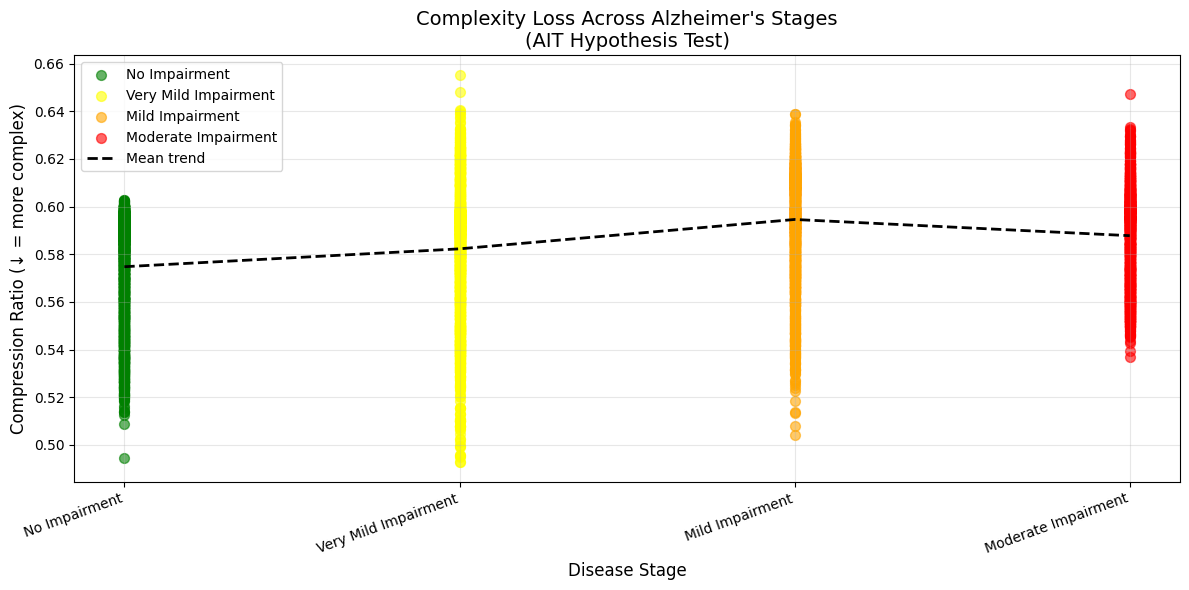


[4/6] EXTRACTING FEATURES
   Processing: 100/9215
   Processing: 200/9215
   Processing: 300/9215
   Processing: 400/9215
   Processing: 500/9215
   Processing: 600/9215
   Processing: 700/9215
   Processing: 800/9215
   Processing: 900/9215
   Processing: 1000/9215
   Processing: 1100/9215
   Processing: 1200/9215
   Processing: 1300/9215
   Processing: 1400/9215
   Processing: 1500/9215
   Processing: 1600/9215
   Processing: 1700/9215
   Processing: 1800/9215
   Processing: 1900/9215
   Processing: 2000/9215
   Processing: 2100/9215
   Processing: 2200/9215
   Processing: 2300/9215
   Processing: 2400/9215
   Processing: 2500/9215
   Processing: 2600/9215
   Processing: 2700/9215
   Processing: 2800/9215
   Processing: 2900/9215
   Processing: 3000/9215
   Processing: 3100/9215
   Processing: 3200/9215
   Processing: 3300/9215
   Processing: 3400/9215
   Processing: 3500/9215
   Processing: 3600/9215
   Processing: 3700/9215
   Processing: 3800/9215
   Processing: 3900/9215
   Proc

In [31]:
    # 1. Charger les données
    print("\n[1/6] LOADING DATASET")
    images, labels, label_names = load_mri_dataset_from_kaggle()
    print(f"\n Total images: {len(images)}")
    print(f" Image shape: {images[0].shape}")
    print(f" Classes: {label_names}")

    # 2. Split
    print("\n[2/6] SPLITTING DATA")
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f" Train: {len(X_train)} | Test: {len(X_test)}")

    # 3. Analyse de complexité
    print("\n[3/6] COMPLEXITY EVOLUTION ANALYSIS")
    plot_complexity_evolution(X_train, y_train, label_names)

    # 4. Extraction de features
    print("\n[4/6] EXTRACTING FEATURES")
    X_train_features = extract_complexity_features(X_train)
    X_test_features = extract_complexity_features(X_test)
    print(f" Feature dimension: {X_train_features.shape[1]}")

    complexities = np.array([kolmogorov_complexity(img) for img in X_train])
    run_full_complexity_analysis(complexities, y_train, label_names)

    # 5. Classification MDL
    print("\n[5/6] MDL CLASSIFICATION")
    y_pred_mdl = mdl_classifier(X_train, y_train, X_test)

In [32]:
    #Classical Classifier
    y_pred_lr = logistic_regression_classifier(X_train_features, y_train, X_test_features)


In [33]:
    y_pred_rf = random_forest_classifier(X_train_features, y_train, X_test_features)


In [34]:
    y_pred_gb = gradient_boosting_classifier(X_train_features, y_train, X_test_features)


In [35]:
    y_pred_svm = svm_classifier(X_train_features, y_train, X_test_features)


 MDL Classifier (AIT-based):
   Accuracy: 29.17%
                      precision    recall  f1-score   support

       No Impairment       0.26      0.62      0.37       640
Very Mild Impairment       0.35      0.10      0.16       602
     Mild Impairment       0.17      0.02      0.04       548
 Moderate Impairment       0.36      0.39      0.38       514

            accuracy                           0.29      2304
           macro avg       0.29      0.28      0.24      2304
        weighted avg       0.29      0.29      0.24      2304


 Random Forest:
   Accuracy: 64.63%
                      precision    recall  f1-score   support

       No Impairment       0.64      0.69      0.66       640
Very Mild Impairment       0.43      0.36      0.39       602
     Mild Impairment       0.67      0.66      0.66       548
 Moderate Impairment       0.82      0.91      0.87       514

            accuracy                           0.65      2304
           macro avg       0.64      0.6

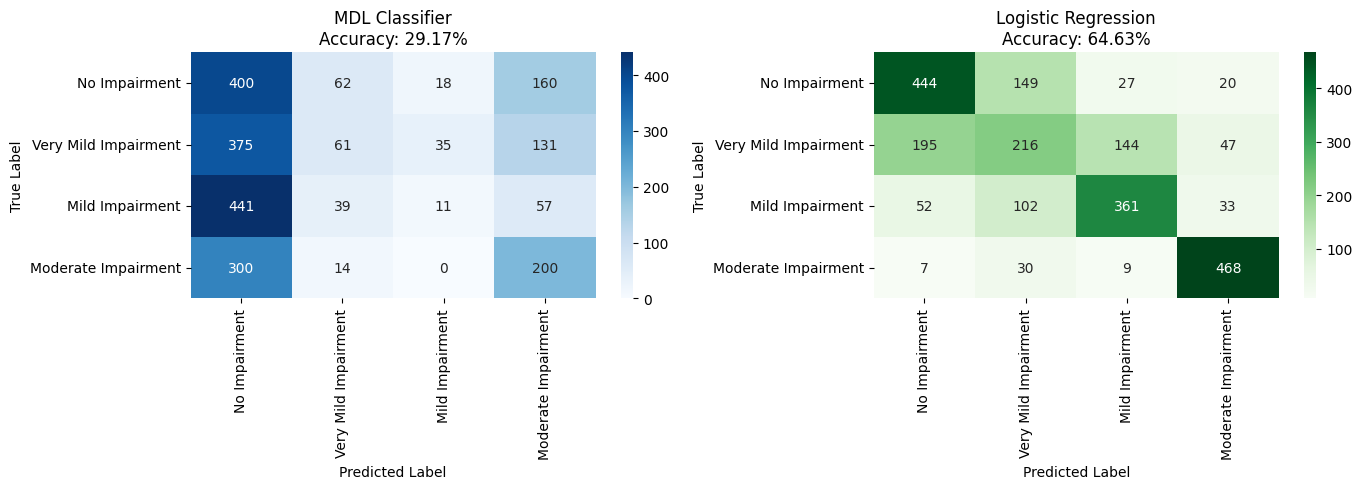


 MDL Classifier (AIT-based):
   Accuracy: 29.17%
                      precision    recall  f1-score   support

       No Impairment       0.26      0.62      0.37       640
Very Mild Impairment       0.35      0.10      0.16       602
     Mild Impairment       0.17      0.02      0.04       548
 Moderate Impairment       0.36      0.39      0.38       514

            accuracy                           0.29      2304
           macro avg       0.29      0.28      0.24      2304
        weighted avg       0.29      0.29      0.24      2304


 Random Forest:
   Accuracy: 73.96%
                      precision    recall  f1-score   support

       No Impairment       0.68      0.75      0.71       640
Very Mild Impairment       0.59      0.53      0.56       602
     Mild Impairment       0.78      0.75      0.76       548
 Moderate Impairment       0.95      0.96      0.95       514

            accuracy                           0.74      2304
           macro avg       0.75      0.7

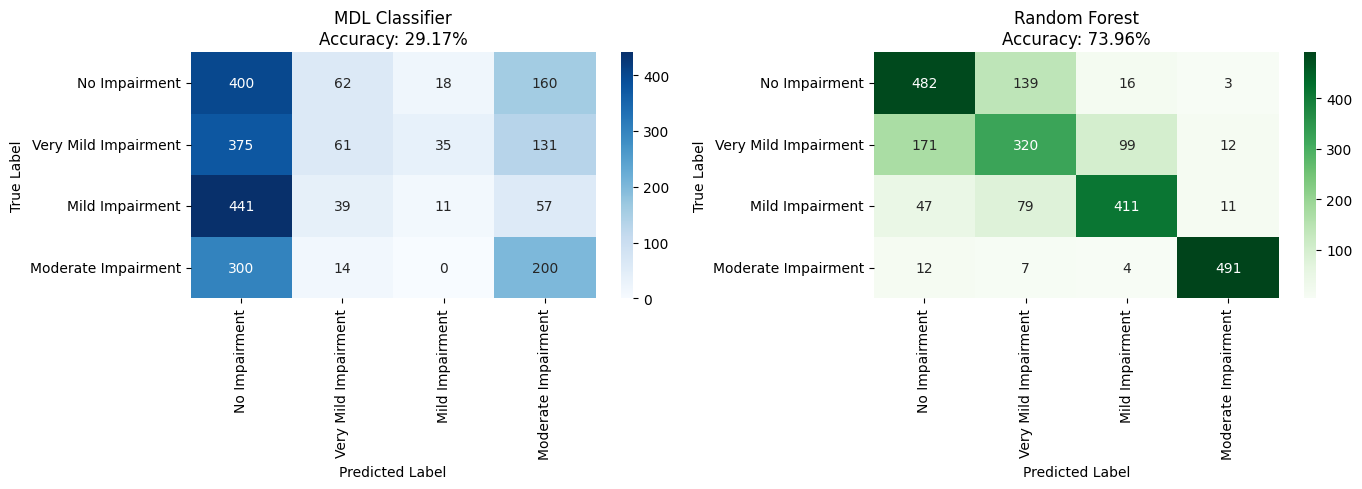


 MDL Classifier (AIT-based):
   Accuracy: 29.17%
                      precision    recall  f1-score   support

       No Impairment       0.26      0.62      0.37       640
Very Mild Impairment       0.35      0.10      0.16       602
     Mild Impairment       0.17      0.02      0.04       548
 Moderate Impairment       0.36      0.39      0.38       514

            accuracy                           0.29      2304
           macro avg       0.29      0.28      0.24      2304
        weighted avg       0.29      0.29      0.24      2304


 Random Forest:
   Accuracy: 67.80%
                      precision    recall  f1-score   support

       No Impairment       0.63      0.70      0.66       640
Very Mild Impairment       0.48      0.49      0.49       602
     Mild Impairment       0.75      0.64      0.69       548
 Moderate Impairment       0.91      0.91      0.91       514

            accuracy                           0.68      2304
           macro avg       0.69      0.6

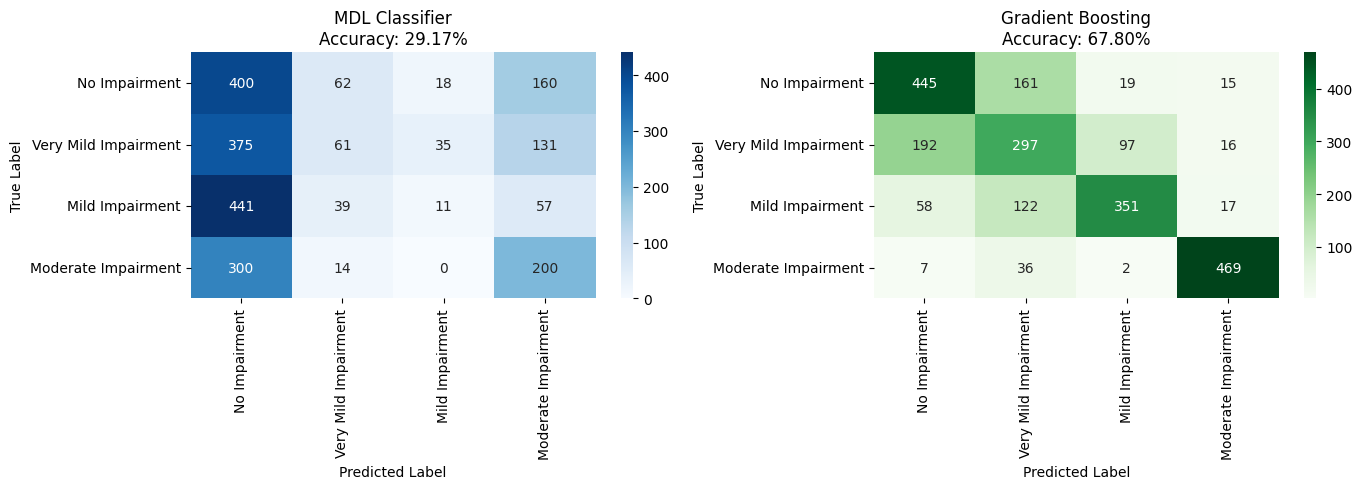


 MDL Classifier (AIT-based):
   Accuracy: 29.17%
                      precision    recall  f1-score   support

       No Impairment       0.26      0.62      0.37       640
Very Mild Impairment       0.35      0.10      0.16       602
     Mild Impairment       0.17      0.02      0.04       548
 Moderate Impairment       0.36      0.39      0.38       514

            accuracy                           0.29      2304
           macro avg       0.29      0.28      0.24      2304
        weighted avg       0.29      0.29      0.24      2304


 Random Forest:
   Accuracy: 64.67%
                      precision    recall  f1-score   support

       No Impairment       0.64      0.69      0.66       640
Very Mild Impairment       0.41      0.41      0.41       602
     Mild Impairment       0.71      0.63      0.67       548
 Moderate Impairment       0.88      0.89      0.88       514

            accuracy                           0.65      2304
           macro avg       0.66      0.6

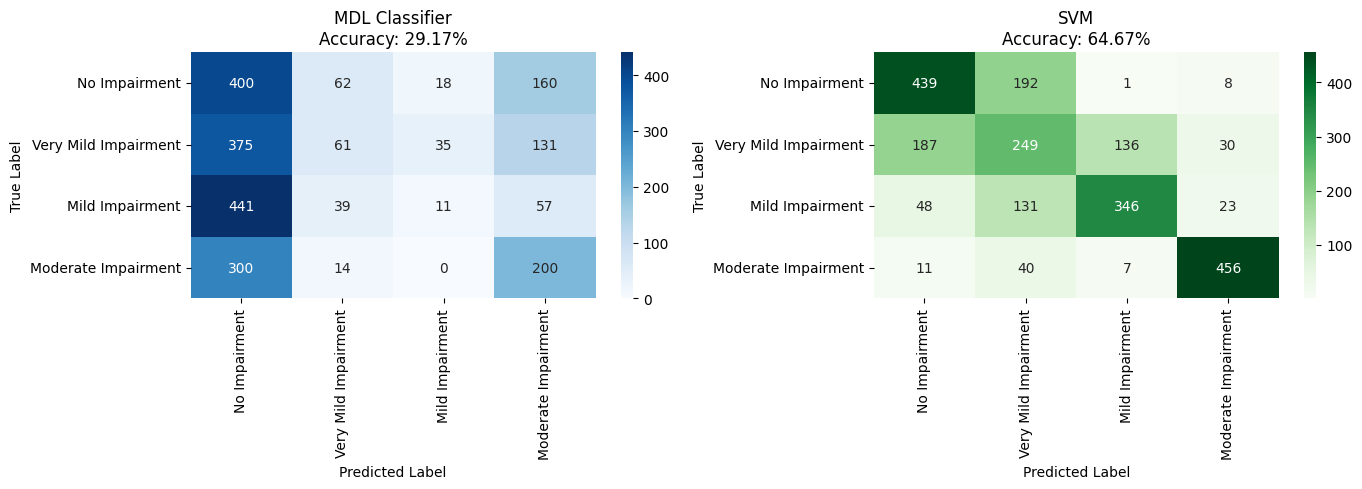

In [36]:
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                          y_pred_mdl,  y_pred_lr,label_names,"MDL Classifier","Logistic Regression")
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl,  y_pred_rf,label_names,"MDL Classifier","Random Forest")

    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl,  y_pred_gb,label_names,"MDL Classifier","Gradient Boosting")
    compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl,  y_pred_svm,label_names,"MDL Classifier","SVM")

In [37]:
y_pred_crt = crt_classifier(X_train, y_train, X_test)


 MDL Classifier (AIT-based):
   Accuracy: 24.39%
                      precision    recall  f1-score   support

       No Impairment       0.22      0.53      0.32       640
Very Mild Impairment       0.28      0.37      0.32       602
     Mild Impairment       0.00      0.00      0.00       548
 Moderate Impairment       0.00      0.00      0.00       514

            accuracy                           0.24      2304
           macro avg       0.13      0.22      0.16      2304
        weighted avg       0.14      0.24      0.17      2304


 Random Forest:
   Accuracy: 73.96%
                      precision    recall  f1-score   support

       No Impairment       0.68      0.75      0.71       640
Very Mild Impairment       0.59      0.53      0.56       602
     Mild Impairment       0.78      0.75      0.76       548
 Moderate Impairment       0.95      0.96      0.95       514

            accuracy                           0.74      2304
           macro avg       0.75      0.7

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


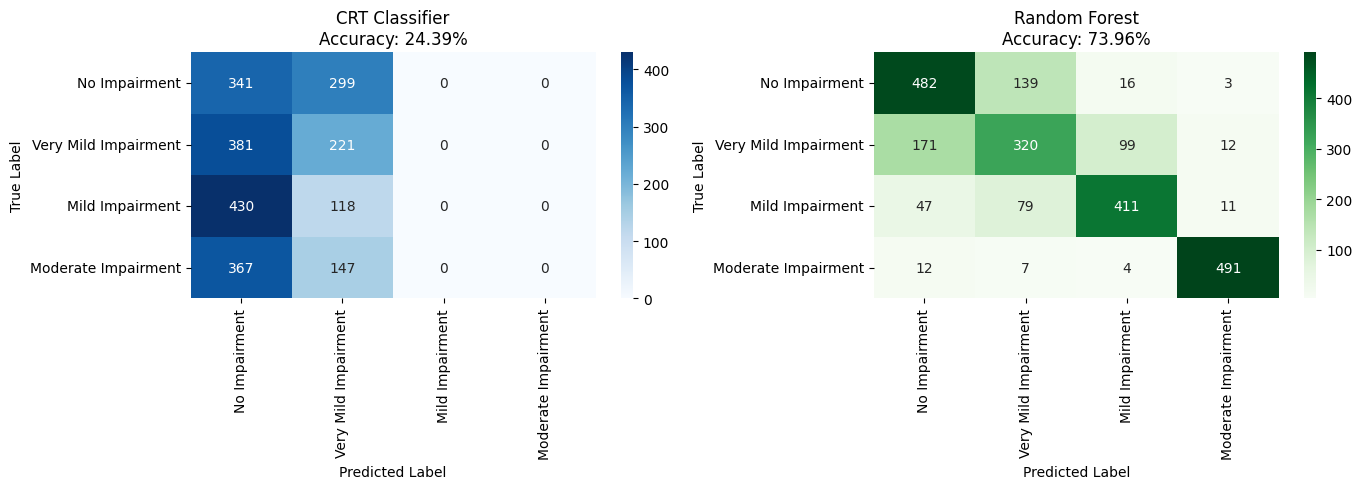

In [38]:
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_crt,  y_pred_rf,label_names,"CRT Classifier","Random Forest")

In [ ]:
y_pred_bnn = bnn_classifier(X_train, y_train, X_test)

In [ ]:
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                          y_pred_bnn,  y_pred_lr,label_names,"BNN Classifier","Logistic Regression")
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_bnn,  y_pred_rf,label_names,"BNN Classifier","Random Forest")
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_bnn,  y_pred_gb,label_names,"BNN Classifier","Gradient Boosting" )
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_bnn,  y_pred_svm,label_names,"BNN Classifier","SVM" )

AIT CLassification features

In [39]:
print("\n[5/6] MDL CLASSIFICATION")
y_pred_mdl_features = mdl_classifier_features(X_train_features, y_train, X_test_features)


[5/6] MDL CLASSIFICATION



 MDL Classifier (AIT-based):
   Accuracy: 33.85%
                      precision    recall  f1-score   support

       No Impairment       0.41      0.48      0.44       640
Very Mild Impairment       0.23      0.10      0.14       602
     Mild Impairment       0.38      0.61      0.47       548
 Moderate Impairment       0.18      0.14      0.16       514

            accuracy                           0.34      2304
           macro avg       0.30      0.34      0.30      2304
        weighted avg       0.31      0.34      0.31      2304


 Random Forest:
   Accuracy: 73.96%
                      precision    recall  f1-score   support

       No Impairment       0.68      0.75      0.71       640
Very Mild Impairment       0.59      0.53      0.56       602
     Mild Impairment       0.78      0.75      0.76       548
 Moderate Impairment       0.95      0.96      0.95       514

            accuracy                           0.74      2304
           macro avg       0.75      0.7

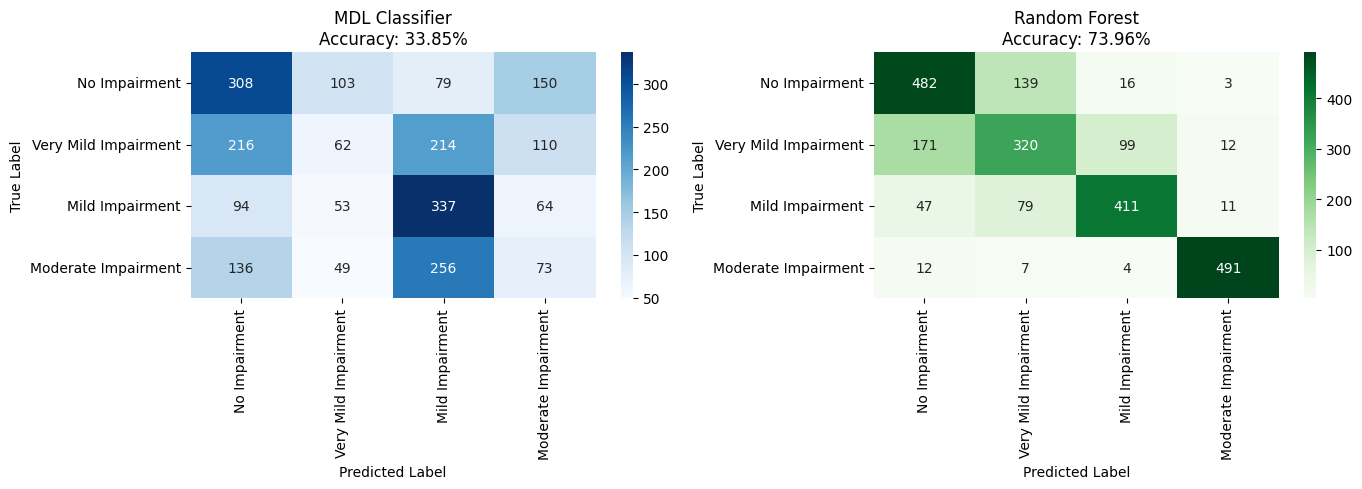

In [40]:
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_mdl_features,  y_pred_rf,label_names,"MDL Classifier","Random Forest")

In [41]:
y_pred_crt_features =  crt_classifier_features(X_train_features, y_train, X_test_features)


 MDL Classifier (AIT-based):
   Accuracy: 26.69%
                      precision    recall  f1-score   support

       No Impairment       0.25      0.52      0.33       640
Very Mild Impairment       0.30      0.47      0.36       602
     Mild Impairment       0.00      0.00      0.00       548
 Moderate Impairment       0.00      0.00      0.00       514

            accuracy                           0.27      2304
           macro avg       0.14      0.25      0.17      2304
        weighted avg       0.15      0.27      0.19      2304


 Random Forest:
   Accuracy: 73.96%
                      precision    recall  f1-score   support

       No Impairment       0.68      0.75      0.71       640
Very Mild Impairment       0.59      0.53      0.56       602
     Mild Impairment       0.78      0.75      0.76       548
 Moderate Impairment       0.95      0.96      0.95       514

            accuracy                           0.74      2304
           macro avg       0.75      0.7

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


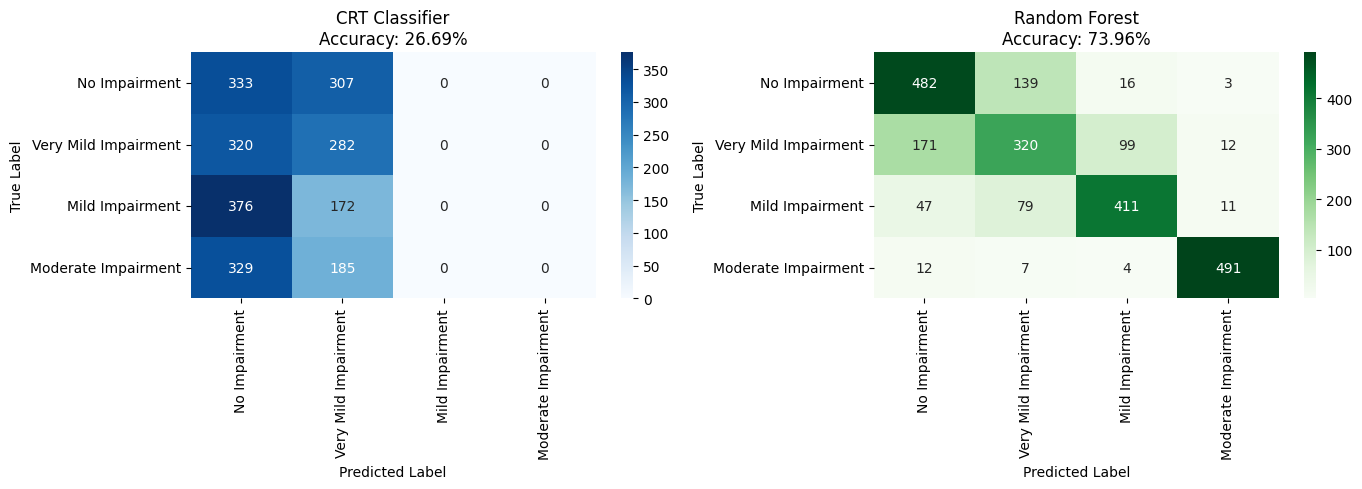

In [42]:
compare_classifiers(X_train_features, y_train, X_test_features, y_test,
                            y_pred_crt_features,  y_pred_rf,label_names,"CRT Classifier","Random Forest")

In [ ]:

y_pred_bnn = bnn_classifier_features(X_train_features, y_train, X_test_features)

Updated Features

In [ ]:
import numpy as np
from skimage.transform import resize
from skimage.filters import sobel
from skimage.measure import shannon_entropy
import gzip, bz2, lzma

# ----- Utility Functions -----

def extract_grid_patches(image, grid_sizes=[4,8]):
    """Divide image into grids of multiple sizes"""
    patches = []
    h, w = image.shape
    for grid in grid_sizes:
        step_h = h // grid
        step_w = w // grid
        for i in range(grid):
            for j in range(grid):
                patch = image[i*step_h:(i+1)*step_h, j*step_w:(j+1)*step_w]
                patches.append(patch)
    return patches

# ----- Main Feature Extraction -----
def extract_rich_features_improved(image):
    features = []
    h, w = image.shape

    # 1. Multi-scale global features
    for scale in [0.25, 0.5, 1.0]:
        resized = resize(image, (int(h*scale), int(w*scale)), anti_aliasing=True)
        resized_uint8 = (resized*255).astype(np.uint8)
        features.append(compress_ratio(resized_uint8, 'gzip'))
        features.append(shannon_entropy(resized_uint8))
        edges = sobel(resized)
        features.append(compress_ratio((edges*255).astype(np.uint8), 'gzip'))

    # 2. Anatomical patches
    patches_anat = {
        'hippocampus': image[int(h*0.5):int(h*0.8), int(w*0.3):int(w*0.7)],
        'cortex_frontal': image[int(h*0.15):int(h*0.3), :],
        'cortex_temporal': image[int(h*0.3):int(h*0.5), :],
        'cortex_parietal': image[int(h*0.15):int(h*0.5), int(w*0.7):],
        'ventricles': image[int(h*0.45):int(h*0.55), int(w*0.45):int(w*0.55)]
    }

    for patch in patches_anat.values():
        patch_uint8 = (patch*255).astype(np.uint8)
        features.append(compress_ratio(patch_uint8, 'gzip'))
        features.append(shannon_entropy(patch_uint8))
        edges = sobel(patch)
        features.append(compress_ratio((edges*255).astype(np.uint8), 'gzip'))

    # 3. Multi-grid patches
    grid_patches = extract_grid_patches(image, grid_sizes=[4,8])
    for patch in grid_patches:
        patch_uint8 = (patch*255).astype(np.uint8)
        features.append(compress_ratio(patch_uint8, 'gzip'))
        features.append(shannon_entropy(patch_uint8))
        edges = sobel(patch)
        features.append(compress_ratio((edges*255).astype(np.uint8), 'gzip'))

    return np.array(features)

# ----- Feature extraction for dataset -----
def extract_features_dataset(images, verbose=True):
    all_features = []
    for idx, img in enumerate(images):
        if verbose and (idx+1) % 50 == 0:
            print(f"Processing {idx+1}/{len(images)}")
        all_features.append(extract_rich_features_improved(img))
    return np.array(all_features)


In [ ]:
# 1. Charger les données
    print("\n[1/6] LOADING DATASET")
    images, labels, label_names = load_mri_dataset_from_kaggle()
    print(f"\n Total images: {len(images)}")
    print(f" Image shape: {images[0].shape}")
    print(f" Classes: {label_names}")

    # 2. Split
    print("\n[2/6] SPLITTING DATA")
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f" Train: {len(X_train)} | Test: {len(X_test)}")

    # 3. Analyse de complexité
    print("\n[3/6] COMPLEXITY EVOLUTION ANALYSIS")
    plot_complexity_evolution(X_train, y_train, label_names)

    # 4. Extraction de features
    print("\n[4/6] EXTRACTING FEATURES")
    X_train_features = extract_features_dataset(X_train)
    X_test_features = extract_features_dataset(X_test)
    print(f" Feature dimension: {X_train_features.shape[1]}")

    print("\n[5/6] MDL CLASSIFICATION")
    y_pred_mdl = mdl_classifier(X_train_features, y_train, X_test_features)


In [ ]:
    y_pred_crt = crt_classifier(X_train_features, y_train, X_test_features)

In [ ]:
    y_pred_bnn = bnn_classifier(X_train_features, y_train, X_test_features)

In [ ]:
y_pred_lr = logistic_regression_classifier(X_train_features, y_train, X_test_features)
y_pred_rf = random_forest_classifier(X_train_features, y_train, X_test_features)
y_pred_gb = gradient_boosting_classifier(X_train_features, y_train, X_test_features)
y_pred_svm = svm_classifier(X_train_features, y_train, X_test_features)
